In [ ]:
pip install mitiq

In [ ]:
pip install qiskit

In [ ]:
pip install ply

In [ ]:
pip install cirq

In [ ]:
import cirq
import numpy as np
from mitiq.benchmarks import generate_rb_circuits
from mitiq import MeasurementResult, Observable, PauliString, raw

#RB CIRCUIT

####GENERATE RB CIRCUIT


In [ ]:
circuit = generate_rb_circuits(2, 1)[0]
print(circuit)

0: ───X────────Y^0.5────────────@───X^0──────Y^-0.5───X^0.5───Y^-0.5───────────────────@───Y^0.5────X^0.5────────────
                                │                                                      │
1: ───Y^-0.5───X^-0.5───Y^0.5───@───X^-0.5───Y^-0.5───X^0.5───Y^-0.5───X^0.5───Y^0.5───@───X^-0.5───Y^-0.5───X^0.5───


In [ ]:
def get_circuit(depth: int, seed: int) -> Tuple[cirq.Circuit, List[int]]:
    circuit, correct_bitstring = generate_rb_circuit(
        n_qubits=2,
        num_cliffords=depth,
        seed=seed,
        return_type="cirq",
    )
    return circuit, correct_bitstring

In [ ]:
def execute(circuit: cirq.Circuit, noise_level: float = 0.002, p0: float = 0.05) -> MeasurementResult:
    """Execute a circuit with depolarizing noise of strength ``noise_level`` and readout errors ...
    """
    measurements = circuit[-1]
    circuit =  circuit[:-1]
    circuit = circuit.with_noise(cirq.depolarize(noise_level))
    circuit.append(cirq.bit_flip(p0).on_each(circuit.all_qubits()))
    circuit.append(measurements)

    simulator = cirq.DensityMatrixSimulator()

    result = simulator.run(circuit, repetitions=10000)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings)

In [ ]:
obs = Observable(PauliString("ZI"), PauliString("IZ"))
noisy = raw.execute(circuit, execute, obs)

In [ ]:
from functools import partial

ideal = raw.execute(circuit, partial(execute, noise_level=0, p0=0), obs)
print("Unmitigated value:", "{:.5f}".format(noisy.real))

Unmitigated value: 1.71900


In [ ]:
from mitiq import zne, benchmarks,pec,rem,ddd

##ZNE METHOD

In [ ]:
zne_executor= zne.mitigate_executor(execute,observable=obs)
zne_result= zne_executor(circuit)
print("Mitigated value obtained with ZNE:", "{:.5f}".format(zne_result.real))

Mitigated value obtained with ZNE: 1.78720


##PEC METHOD

In [ ]:
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

noise_level = 0.005
reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)  ## reps necessary for PEC METHOD
print(f"{len(reps)} OperationRepresentation objects produced, assuming {100 * noise_level}% depolarizing noise.")

10 OperationRepresentation objects produced, assuming 0.5% depolarizing noise.


In [ ]:
pec_executor= pec.mitigate_executor(execute,observable=obs,representations=reps)
pec_result= pec_executor(circuit)
print("Mitigated value obtained with PEC:", "{:.5f}".format(pec_result.real))


Mitigated value obtained with PEC: 1.83042


##DDD METHOD

In [ ]:
rule = ddd.rules.yy

In [ ]:
ddd_executor= ddd.mitigate_executor(execute,observable=obs,rule=rule)
ddd_result= ddd_executor(circuit)
print("Mitigated value obtained with DDD:", "{:.5f}".format(ddd_result.real))


Mitigated value obtained with DDD: 1.73300


##REM METHOD

In [ ]:
p0 = p1 = 0.05
icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
rem_executor = rem.mitigate_executor(execute, inverse_confusion_matrix=icm)

rem_result = obs.expectation(circuit, rem_executor)
print("Mitigated value obtained with REM:", "{:.5f}".format(rem_result.real))

Mitigated value obtained with REM: 1.89080


## COMBINEND METHOD

###ZNE+REM

In [ ]:
combined_executor1 = zne.mitigate_executor(rem_executor, observable=obs, scale_noise=zne.scaling.folding.fold_global)

combined_result = combined_executor1(circuit)
print("Mitigated value obtained with REM + ZNE:", "{:.5f}".format(combined_result.real))

Mitigated value obtained with REM + ZNE: 2.03720


###PEC+REM

In [ ]:
combined_executor = pec.mitigate_executor(rem_executor, observable=obs,representations=reps)

combined_result = combined_executor(circuit)
print("Mitigated value obtained with PEC+REM:", "{:.5f}".format(combined_result.real))

/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───Y^0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───X───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───X^-0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───Y^0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───@───
      │
1: ───@───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───Y^-0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───Y^0.5───.
  warnings

Mitigated value obtained with PEC+REM: 1.91416


###ZNE+REM+PEC

In [ ]:
combined_executor_total = pec.mitigate_executor(combined_executor1,representations=reps)

combined_result2 = combined_executor_total(circuit)
print("Mitigated value obtained with REM + PEC + ZNE:", "{:.5f}".format(combined_result2.real))

/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───Y^0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───X───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───X^-0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───Y^0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───@───
      │
1: ───@───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

0: ───Y^-0.5───.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mitiq/pec/sampling.py:75: UserWarning: No representation found for 

1: ───Y^0.5───.
  warnings

AttributeError: 'NoneType' object has no attribute '_expectation_from_measurements'

In [ ]:
# Random seed for circuit generation.
seed = 1

# Total number of shots to use.
shots: int = 10000

# Qubits to use on the experiment.
qubits = [0, 1, 2]

# Average results over this many trials (circuit instances) at each depth.
trials = 3

# Clifford depths.
depths = [1, 2, 3]


In [ ]:
import functools
from typing import List, Tuple



In [ ]:
from mitiq.benchmarks import generate_rb_circuits

In [ ]:
def get_circuit(depth: int, seed: int) -> Tuple[cirq.Circuit, List[int]]:
    circuit =generate_rb_circuits(
        n_qubits=2,
        num_cliffords=depth,
        return_type="cirq",
        seed=seed,
    )
    return circuit

In [ ]:
true_values, noisy_values = [], []
ddd_values = [] #
zne_values=[]
pec_values=[]
rem_values=[]

noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")

    true_depth_values, noisy_depth_values, ddd_depth_values,zne_depth_values,pec_depth_values,rem_depth_values = [], [], [],[], [], []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeated values in loop.
        local_seed = 10**6 * depth + 10**3 * seed + trial

        circuit = get_circuit(depth, local_seed)

        true_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0), obs)
        noisy_value = raw.execute(circuit, execute, obs)
        noisy_executor = functools.partial(
            execute,
            shots=shots)

#print("Unmitigated value:", "{:.5f}".format(noisy.real))
        ddd_value = ddd.execute_with_ddd(
           circuit,
           noisy_executor,
           rule=rule,
       )
      #  ddd_executor= ddd.mitigate_executor(noisy_executor,observable=obs,rule=rule)
       # ddd_value=ddd_executor(circuit)



        ddd_depth_values.append(ddd_value)

        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)

    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)
    ddd_values.append(ddd_depth_values)

Status: On depth 1



TypeError: unsupported callable

In [ ]:
ddd_executor= ddd.mitigate_executor(execute,observable=obs,rule=rule)
ddd_result= ddd_executor(circuit)
print("Mitigated value obtained with DDD:", "{:.5f}".format(ddd_result.real))


#MIRROR CIRCUITS

In [ ]:
from mitiq.benchmarks import generate_mirror_circuits
import functools
from typing import List, Tuple
import networkx as nx
import numpy as np
# Plotting imports.
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline
from mitiq import ddd

ImportError: cannot import name 'generate_mirror_circuits' from 'mitiq.benchmarks' (/usr/local/lib/python3.10/dist-packages/mitiq/benchmarks/__init__.py)

In [ ]:
import functools
from typing import List, Tuple

# Plotting imports.
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

# Third-party imports.
import cirq

import networkx as nx
import numpy as np

# Mitiq imports.
from mitiq import benchmarks, ddd

In [ ]:
# Random seed for circuit generation.
seed = 1

# Total number of shots to use.
shots: int = 10000

# Qubits to use on the experiment.
qubits = [0, 1, 2]

# Average results over this many trials (circuit instances) at each depth.
trials = 3

# Clifford depths.
depths = [10, 20, 30]

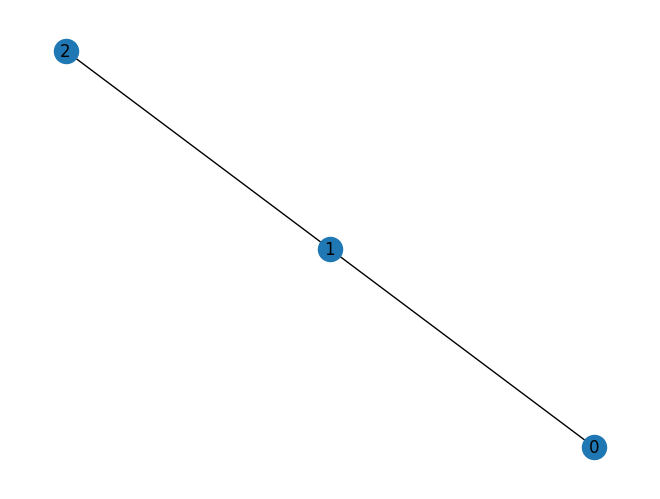

In [ ]:
# Assume chain-like connectivity
topology = nx.Graph()
topology.add_edges_from([(0, 1), (1, 2)])
nx.draw(topology, with_labels=True)

# Add reversed edges to topology graph.
# This is important to represent CNOT gates with target and control reversed.
topology = nx.to_directed(topology)

##GENERATE MIRROR CIRCUIT


In [ ]:
def get_circuit(depth: int, seed: int) -> Tuple[cirq.Circuit, List[int]]:
    circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
        nlayers=depth,
        two_qubit_gate_prob=1.0,
        connectivity_graph=topology,
        two_qubit_gate_name="CNOT",
        seed=seed,
        return_type="cirq",
    )
    return circuit, correct_bitstring

In [ ]:
print(circuit)

0: ───X────────Y^-0.5───I───@────────────────I───@──────────────I───Y^-0.5───X^-0.5───Y^0.5───Y───X^0.5───Y^0───Y───Y^-0.5───X^0.5───Y^-0.5───Z───@────────────────────────I───@─────────I───@──────────────Y───Y───X───X───@─────────────Z───Y^0.5───X^0.5───Z───Y^-0.5───X^0.5───Z───Y^-0.5───X^0.5───Y^-0.5───X───X^-0.5───Y^0.5───I───Y^0.5───X^-0.5───Y───@────────────────X───X^-0.5───Y^0───Z───@───────────I───Y^-0.5───X^-0.5───X───Y^-0.5───X^0.5───Y^-0.5───Y───@───────────I───@──────────────I───@────────────Y───@──────────────Y───X───Y^0───X───X^0───X───@─────X───@─────────────────Z───X^-0.5───Y^-0.5───X───@───────────X────────────@───Z───Y^0.5───X^0.5───X───────────@───────X───@─────I───X^0───Y───Y^0───X───I─────────@───────Z───────────@───Z─────────@───────I────────────@───I───Y^0.5───X^-0.5───Y^0.5───Z───X^0.5───Y^0.5───Y────────────@───Z───Y^0───X^0.5───Z───────────@────────Z───X^0.5───Y^-0.5───X───Y^-0.5───X^0.5───Y───Y^0.5───X^-0.5───Y^0.5───Z───X^-0.5───Y^0.5───Y───X^-0.5───Y^-0.5───X

In [ ]:
circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
    nlayers=1,
    two_qubit_gate_prob=1.0,
    two_qubit_gate_name="CZ",
    connectivity_graph=connectivity_graph,
    seed=1,
    return_type="braket",
)
print(circuit)
print("\nShould sample:", correct_bitstring)

TypeError: generate_mirror_circuit() missing 1 required positional argument: 'connectivity_graph'

### DEFINE THE EXECUTOR FOR MIRROR CIRCUIT

In [ ]:
def execute(
    circuit: cirq.Circuit,
    shots: 100,
    correct_bitstring: List[int],
    is_noisy: bool = True,
) -> float:
    """Executes the input circuit(s) and returns ⟨A⟩, where
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    # This is useful to understand if DDD gates are inserted into the circuit.
    print(f"Executing circuit with {len(list(circuit.all_operations()))} gates.")
    if is_noisy:
        # Simulate systematic dephasing (coherent RZ) on each qubit for each moment.
        circuit_to_run = circuit.with_noise(cirq.rz(0.05))
    else:
        circuit_to_run = circuit.copy()

    circuit_to_run += cirq.measure(*sorted(circuit.all_qubits()), key="m")
    backend = cirq.DensityMatrixSimulator()

    result = backend.run(circuit_to_run, repetitions=shots)
    expval = result.measurements["m"].tolist().count(correct_bitstring) / shots
    return expval

In [ ]:
from mitiq import ddd

rule = ddd.rules.yy

##BITSTRINGS FOR MIRROR CIRCUITS

In [ ]:
true_values, noisy_values = [], []
ddd_values = []

noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")

    true_depth_values, noisy_depth_values, ddd_depth_values = [], [], []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeated values in loop.
        local_seed = 10**6 * depth + 10**3 * seed + trial

        circuit, correct_bitstring = get_circuit(depth, local_seed)

        true_value = execute(circuit, shots, correct_bitstring, is_noisy=False)
        noisy_value = execute(circuit, shots, correct_bitstring, is_noisy=True)

        noisy_executor = functools.partial(
            execute,
            shots=shots,
            correct_bitstring=correct_bitstring,
        )

        ddd_value = ddd.execute_with_ddd(
            circuit,
            noisy_executor,
            rule=rule,
        )

        ddd_depth_values.append(ddd_value)

        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)

    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)
    ddd_values.append(ddd_depth_values)

Status: On depth 10

Executing circuit with 137 gates.
Executing circuit with 137 gates.
Executing circuit with 157 gates.
Executing circuit with 145 gates.
Executing circuit with 145 gates.
Executing circuit with 180 gates.
Executing circuit with 147 gates.
Executing circuit with 147 gates.
Executing circuit with 178 gates.
Status: On depth 20

Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 303 gates.
Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 308 gates.
Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 317 gates.
Status: On depth 30

Executing circuit with 383 gates.
Executing circuit with 383 gates.
Executing circuit with 447 gates.
Executing circuit with 375 gates.
Executing circuit with 375 gates.
Executing circuit with 420 gates.
Executing circuit with 381 gates.
Executing circuit with 381 gates.
Executing circuit with 449 gates.


##VISUALIZATION OF RESULTS

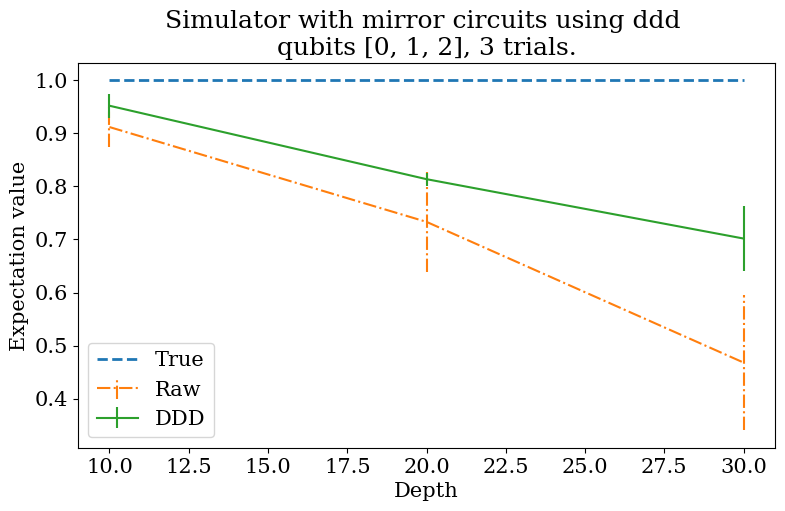

In [ ]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

avg_ddd_values = np.average(ddd_values, axis=1)
std_ddd_values = np.std(ddd_values, axis=1, ddof=1)

plt.figure(figsize=(9, 5))

plt.plot(depths, avg_true_values, "--", label="True", lw=2)
eb = plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", ls="-.")
eb[-1][0].set_linestyle("-.")
plt.errorbar(depths, avg_ddd_values, yerr=std_ddd_values, label="DDD")

plt.title(
    f"""Simulator with mirror circuits using ddd \nqubits {qubits}, {trials} trials."""
)
plt.xlabel("Depth")
plt.ylabel("Expectation value")
_ = plt.legend()

In [ ]:
zne_value = zne.execute_with_zne(circuit, execute)  # Noisy quantum computer + Mitiq ZNE METHODb

TypeError: execute() missing 2 required positional arguments: 'shots' and 'correct_bitstring'

In [ ]:
zne_value = zne.execute_with_zne(
    circuit,
    execute,
    scale_noise=zne.scaling.fold_global,
    factory=zne.inference.PolyFactory(scale_factors=[1, 3, 5], order=2)
)
print("ZNE value:", zne_value)

TypeError: execute() missing 2 required positional arguments: 'shots' and 'correct_bitstring'